# Predicting stock movement with Twitter

Laia Antonijoan

December 20, 2020



## Summary

One of the criticisms of the stock market is that stock value is not determined by fundamentals (the actual value of the company: assets, revenue, liabilities,...), instead, stock value is determined by the emotions of the traders, what is called "market sentiment".

This is a fair criticism as fundamentals alone cannot predict the value of a stock. So, if market sentiment helps determine the value of a company, how can we capture the market sentiment?

My assumption is that market sentiment can be captured with tweets. Tweets are the messages exchanged on Twitter, an online platform where users post opinions and information in real-time. The reasons why Twitter can be a good platform to capture sentiment are:

- **Allows expressing sentiment:** Tweets have a maximum length of 280 characters, which is a perfect size, it is not too long that will make computing the sentiment too complex, or too short that doesn't allow to express opinions or thoughts. Even though tweets are much shorter than traditional new reports, Tweets have enough length to express points of view and are faster to process than lengthy news reports.
- **Immediate:** users in the platform respond immediately, in real-time. Because of the quick reactions, users express their real opinions, sometimes, unfiltered. This makes Twitter more advantageous than capturing news. News report on what happened yesterday, while Twitter captures what is happening now. Capturing what is happening now vs. what happened yesterday is key because it will help us predict.
- **Popular:** with 500 million tweets per day, Twitter is a popular platform that generates a lot of data. It will be easy to have enough data to have a robust analysis. This is another advantage of Twitter versus traditional news. The news might publish opinions on a specific stock once in a while, which will not give us enough daily data points to be able to assess sentiment.
- **Easy to collect:** it is possible to access tweets as Twitter grants APIs and there are a few Python libraries to help capture tweets.

But using tweets to capture sentiment also has its challenges:
- **Language:** the language used in Twitter doesn't always follow the conventional orthographic rules which is a challenge when we are trying to capture words.
- **Limit on the number of tweets captured:** capturing tweets has been more challenging than I expected. Twitter grants APIs with limitations on how many tweets can be captured.

Even though tweets are not perfect to capture sentiment, overall they have more advantages than disadvantages. And because of length and speed tweets are more preferable than news, the other option to capture the sentiment. 

Therefore, we will use Twitter to capture the sentiment of specific stock values. But we will not stop once we have captured the sentiment, the second step will be testing if the sentiment for specific stocks can be a good predictor of the stock market movement of the following day.

The project will be accomplished in two steps:\
1 - Estimate the sentiment of real tweets for specific stocks; and\
2 - Test if the sentiment is a good predictor of the stock value movement.

**1 - Estimate Sentiment**

To estimate the sentiment of tweets we are going to:\
1 - Train a model using a Twitter Kaggle dataset with a pre-labelled sentiment.\
2 - Once we have the trained model, we are going to use the model to assess the sentiment of current tweets.


**2 - Predicting stock movement**

Once we have the sentiment of the tweets, we will see if the sentiment predicts the movement of the next day's stock value. For this, we will need stock value data that we will extract from Yahoo Finance.


To start we need to install in the terminal:

`pip install nltk`\ 
`pip install tweet-preprocessor`\
`pip install wordcloud`\
`pip install yfinance --upgrade --no-cache-dir`\


## 1. Estimating sentiment

In [1]:
# Importing necessary libraries

import pandas as pd  
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import datetime as dt
import time
import nltk
import warnings
warnings.filterwarnings('ignore')
from alpha_vantage.timeseries import TimeSeries
%matplotlib inline

# To be able to use NLTK(Natural Language Toolkit) we need to have previously installed in your 
# terminal: pip install nltk

# Also in terminal python -m nltk.downloader popular


In [2]:
# Importing Kaggle training data set

twitter_positive = pd.read_json('data/twitter_samples/positive_tweets.json', lines=True)
twitter_negative = pd.read_json('data/twitter_samples/negative_tweets.json', lines=True)

# Source: https://www.kaggle.com/nltkdata/twitter-sample

### 1.1. Exploratory Data Analysis

We are going to explore the data set.

In [3]:
print(f'The data set with the positive tweets has {twitter_positive.shape[0]} rows and {twitter_positive.shape[1]} columns')
print(f'The data set with the negative tweets has {twitter_negative.shape[0]} rows and {twitter_negative.shape[1]} columns')

The data set with the positive tweets has 5000 rows and 28 columns
The data set with the negative tweets has 5000 rows and 28 columns


In [4]:
# Looking at the data set

twitter_positive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   contributors               0 non-null      float64            
 1   coordinates                27 non-null     object             
 2   text                       5000 non-null   object             
 3   user                       5000 non-null   object             
 4   retweet_count              5000 non-null   int64              
 5   favorited                  5000 non-null   bool               
 6   entities                   5000 non-null   object             
 7   source                     5000 non-null   object             
 8   truncated                  5000 non-null   bool               
 9   geo                        27 non-null     object             
 10  in_reply_to_status_id_str  2453 non-null   float64            
 11  is_q

In [9]:
twitter_negative.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   contributors               0 non-null      float64            
 1   coordinates                36 non-null     object             
 2   text                       5000 non-null   object             
 3   user                       5000 non-null   object             
 4   retweet_count              5000 non-null   int64              
 5   favorited                  5000 non-null   bool               
 6   entities                   5000 non-null   object             
 7   source                     5000 non-null   object             
 8   truncated                  5000 non-null   bool               
 9   geo                        36 non-null     object             
 10  in_reply_to_status_id_str  2057 non-null   float64            
 11  is_q

After looking at the columns, we only need the time when the tweet was tweeted (column `created_at`) and the tweet per se (column `text`)

In [10]:
tp = twitter_positive[['created_at', 'text']]
tn = twitter_negative[['created_at', 'text']]

In [11]:
# Adding the sentiment columnt to both data sets

tp['Sentiment'] = 1
tn['Sentiment'] = 0

In [104]:
# Putting all the tweets together

tweets = pd.concat([tp, tn], ignore_index=True)

In [75]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   created_at  10000 non-null  datetime64[ns, UTC]
 1   text        10000 non-null  object             
 2   Sentiment   10000 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 234.5+ KB


In [94]:
tweets

,created_at,text,Sentiment
0,2015-07-24 08:23:36+00:00,#FollowFriday @France_Inte @PKuchly57 @Milipol...,1
1,2015-07-24 08:23:35+00:00,@Lamb2ja Hey James! How odd :/ Please call our...,1
2,2015-07-24 08:23:35+00:00,@DespiteOfficial we had a listen last night :)...,1
3,2015-07-24 08:23:35+00:00,@97sides CONGRATS :),1
4,2015-07-24 08:23:34+00:00,yeaaaah yippppy!!! my accnt verified rqst has...,1
...,...,...,...
9995,2015-07-24 09:49:40+00:00,I wanna change my avi but uSanele :(,0
9996,2015-07-24 09:49:40+00:00,MY PUPPY BROKE HER FOOT :(,0
9997,2015-07-24 09:49:38+00:00,where's all the jaebum baby pictures :((,0
9998,2015-07-24 09:49:38+00:00,But but Mr Ahmad Maslan cooks too :( https://t...,0


In [77]:
# Checking we don't have any repeated tweets

len(tweets['text'].unique())

10000

In [78]:
# All the tweets were created in one day

print(f"Number of days in the data set: {len(tweets['created_at'].dt.date.unique())}")
print(f"The days are: {tweets['created_at'].dt.date.unique()}")
                                

Number of days in the data set: 1
The days are: [datetime.date(2015, 7, 24)]


In [20]:
# When was the first tweet captured

tweets.sort_values(by='created_at', ascending=True).head(1)

,created_at,text,Sentiment
4999,2015-07-24 08:11:16+00:00,@DanielOConnel18 you could say he will have eg...,1


In [19]:
# When was the last tweet captured

tweets.sort_values(by='created_at', ascending=False).head(1)

,created_at,text,Sentiment
5000,2015-07-24 10:42:49+00:00,hopeless for tmr :(,0


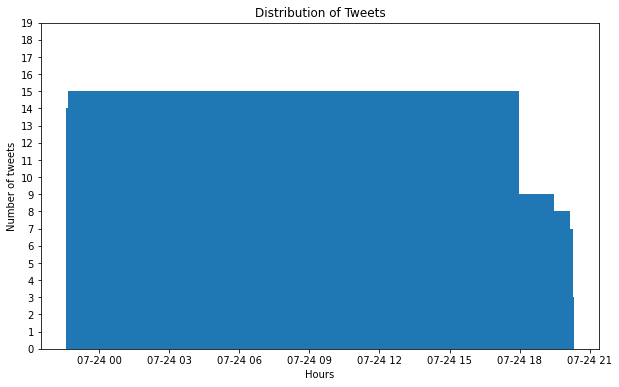

In [502]:
plt.figure(figsize=(10,6))
plt.bar(tweets['created_at'].value_counts().index, 
        tweets['created_at'].value_counts().values)
plt.xlabel('Hours')
plt.ylabel('Number of tweets')
plt.title('Distribution of Tweets')
#plt.xticks(tweets['created_at'].value_counts().index)
plt.yticks(range(0, max(tweets['created_at'].value_counts().values)+5))
plt.show()

The tweets were tweeted in July 24th 2015 between 8:11 am and 10:42 am

### 1.2. Cleaning the `text` column

Twitter is not well not know for its proper writing. We need to clean text from the `text` column.

We want to:
- Remove any HTML code that could have been captured.
- Remove all the hyperlinks.
- Remove all the usernames because they will not give us any information about the emotions.
- Remove the symbol `#` but leave the rest of the word as hashtags can sometimes express emotions.
- Transform all the letters in uppercase to lowercase.
- Remove words with numbers.
- Remove stopwords: very common words in English (like for, the,..) but they don't add any "sentiment" meaning.
- Remove punctuation.
- We will apply lemmatization to the words: lemmatization reduces related words to a common lemma, that is once the function of the word has been defined it applies different steaming rules, for example: `dove` as a verb will be turned into `dive`, while `dove` as a noun it will still be `dove`. That is why before applying the lemmatization we will need to predefine a function that will tag the function that each word has in a sentence.

In [105]:
tweets

,created_at,text,Sentiment
0,2015-07-24 08:23:36+00:00,#FollowFriday @France_Inte @PKuchly57 @Milipol...,1
1,2015-07-24 08:23:35+00:00,@Lamb2ja Hey James! How odd :/ Please call our...,1
2,2015-07-24 08:23:35+00:00,@DespiteOfficial we had a listen last night :)...,1
3,2015-07-24 08:23:35+00:00,@97sides CONGRATS :),1
4,2015-07-24 08:23:34+00:00,yeaaaah yippppy!!! my accnt verified rqst has...,1
...,...,...,...
9995,2015-07-24 09:49:40+00:00,I wanna change my avi but uSanele :(,0
9996,2015-07-24 09:49:40+00:00,MY PUPPY BROKE HER FOOT :(,0
9997,2015-07-24 09:49:38+00:00,where's all the jaebum baby pictures :((,0
9998,2015-07-24 09:49:38+00:00,But but Mr Ahmad Maslan cooks too :( https://t...,0


In [184]:
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Assing a tage to every word if it corresponds to and adjecive, verb, noun or adverb 
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_tweet(tweet):
    # Removes HTMLs
    tweet = re.sub(r'\&\w*;', '', tweet)
    # Removes hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Removes @usernames
    tweet = re.sub('@[^\s]+','',tweet)
    # Removes hashtags
    tweet = re.sub(r'#', '', tweet)
    # Converts all text to lower case
    tweet = tweet.lower()
    # Removes punctuation
    tweet = [word.strip(string.punctuation) for word in tweet.split(" ")]
    # Removes words that contain any numbers
    tweet = [word for word in tweet if not any(c.isdigit() for c in word)]
    # Removes stop words: words that are common but have no meaningn
    stop = stopwords.words('english')
    tweet = [x for x in tweet if x not in stop]
    # Remove empty words
    tweet = [t for t in tweet if len(t) > 0]
    # Tags position in the text 
    pos_tags = pos_tag(tweet)
    # Lemmatizes the tweets
    tweet = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # Remove words with only one letter
    tweet = [t for t in tweet if len(t) > 1]
    # join all
    tweet = " ".join(tweet)
    return(tweet)

# clean tweets 
tweets["text"] = tweets["text"].apply(lambda x: clean_tweet(x))

In [107]:
tweets

,created_at,text,Sentiment
0,2015-07-24 08:23:36+00:00,followfriday top engaged member community week,1
1,2015-07-24 08:23:35+00:00,hey james odd please call contact centre able ...,1
2,2015-07-24 08:23:35+00:00,listen last night bleed amazing track scotland,1
3,2015-07-24 08:23:35+00:00,congrats,1
4,2015-07-24 08:23:34+00:00,yeaaaah yippppy accnt verify rqst succeed get ...,1
...,...,...,...
9995,2015-07-24 09:49:40+00:00,wanna change avi usanele,0
9996,2015-07-24 09:49:40+00:00,puppy break foot,0
9997,2015-07-24 09:49:38+00:00,where's jaebum baby picture,0
9998,2015-07-24 09:49:38+00:00,mr ahmad maslan cook,0


In [82]:
# We want to save the clean tweets

tweets.to_csv(r'data/clean_tweets.csv')

### 1.3. Tokenizing

In this section we are going to tokenize the tweets, that is we will turn each word into a token and then we will vectorize using both Bag of Words and TF-IDF.

In [590]:
tweets = pd.read_csv(r'data/clean_tweets.csv')

In [596]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9993 entries, 0 to 9992
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  9993 non-null   int64 
 1   created_at  9993 non-null   object
 2   text        9993 non-null   object
 3   Sentiment   9993 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 312.4+ KB


In [597]:
tweets.drop('Unnamed: 0', axis=1, inplace=True)

In [599]:
# convert the 'Date' column to datetime format
tweets['created_at']= pd.to_datetime(tweets['created_at'])

In [108]:
X = tweets['text']
y = tweets['Sentiment']

In [109]:
# Splitting our data into train and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [87]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7000,) (3000,) (7000,) (3000,)


Once we have split the tweets data set into two data sets:
- Train data set: which we will use to train the model
- Test data set: which we will use to test the real accuracy of the model. It will help us simulate how the model will work in real life.

We apply the vectorization after the train/test split because the test data set will help us assess how good the model is in real life and therefore we need to make sure the train model doesn't "see" any of the words of the test data set.

Now we can apply two different types of vectorization:

**1 - Bag of Words:** it will create a vocabulary of all the unique words (tokens) occurring in all the tweets training set. And it will count how many times the words appears.

**2 - TF-IDF:** stands for Term Frequency-Inverse Document Frequency, which is a value calculated in two steps:
- TF -Term Frequency: the frequency in which a words appears in the document = number of times the word appears in the document / total number of terms in the document
- IDF Inverse Document Frequency: measures how important a document is, some words are very common (like that, is, am,...) but they are not that important, to weight down the words that appear frequently = log_e(total number of documents / number of documents with the word in it)

In [110]:
from sklearn.feature_extraction.text import CountVectorizer

# 1. Instantiate
bagofwords = CountVectorizer(strip_accents='unicode', tokenizer=None, stop_words ='english', 
                             analyzer='word', min_df = 2)

# 2. Fit
bagofwords.fit(X_train)

# 3. Transform
X_train_BoW = bagofwords.transform(X_train)
X_test_BoW = bagofwords.transform(X_test)


In [111]:
# Converting the sparse matrix into a Pandas data frame

BoW = pd.DataFrame(X_train_BoW.toarray())
BoW.columns = bagofwords.get_feature_names()
BoW

,aa,aameen,abby,abhi,able,aboard,abp,abroad,absolute,absolutely,...,yung,yup,zayn,zayniscomingback,zone,zonzofox,عن,غردلي,더쇼,에이핑크
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


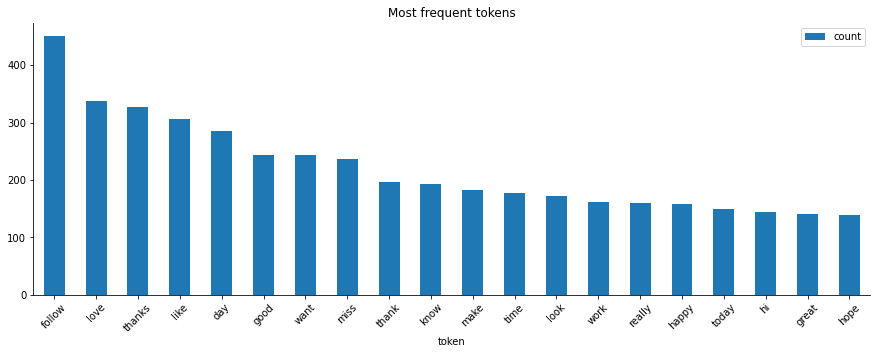

In [112]:
import seaborn as sns

words = bagofwords.get_feature_names()
word_counts = X_train_BoW.toarray().sum(axis=0)

def plot_most_frequent(words, word_counts, top=20):
    words_df = pd.DataFrame({"token": words, 
                             "count": word_counts})
    
    fig, ax = plt.subplots(figsize=(0.75*top, 5))
    words_df.sort_values(by="count", ascending=False).head(top)\
        .set_index("token")\
        .plot(kind="bar", rot=45, ax=ax)
    sns.despine()
    plt.title("Most frequent tokens")
    plt.show()
    
plot_most_frequent(words, word_counts)

In [113]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorizing the text column

tfidf = TfidfVectorizer(max_features=10000, 
                                 min_df=0.0001, max_df=0.2, 
                                 stop_words=stopwords.words('english'),
                                 token_pattern=r'\b[^\d\W]+\b',
                                 strip_accents = "ascii")

X_train_TFIDF = tfidf.fit_transform(X_train)
X_test_TFIDF = tfidf.transform(X_test)

In [114]:
TFIDF = pd.DataFrame(X_train_TFIDF.toarray())
TFIDF.columns = tfidf.get_feature_names()
TFIDF

,_,aa,aaaaaaaaaaaaa,aaaaahhhhhhhh,aaaahh,aaahhh,aah,aahhhh,aameen,aamir,...,zone,zonzofox,zoo,zoom,zopiclone,zorroreturms,zy,zz,zzz,zzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


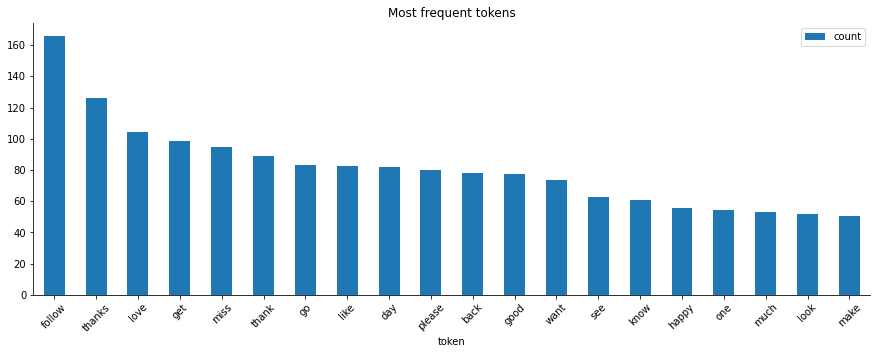

In [115]:
words_tfidf = tfidf.get_feature_names()
word_weights_tfidf = X_train_TFIDF.toarray().sum(axis=0)

plot_most_frequent(words_tfidf, word_weights_tfidf)

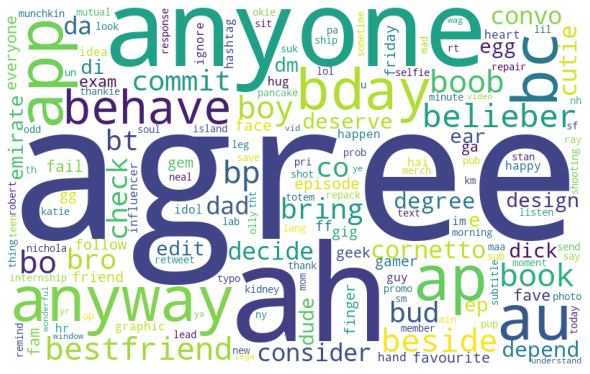

In [116]:
# To use the WordCloud it previously needs to be intalled through the termianl ->$ pip install wordcloud

from PIL import Image
from os import path
from wordcloud import WordCloud, STOPWORDS
from IPython.display import Image as im


temp=' '.join(words_tfidf)
wordcloud = WordCloud(width = 800, height = 500, 
                background_color ='white', 
                min_font_size = 10).generate(temp)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()

### 1.4.A Finding the most optimal supervised learning model - Logistic Regression

In this section we are going to try to find the model that give us the supervised learning model that give us the best accuracy.

First we are going to start using a logistic regression model to help us decide which vectorizer to use. We will choose the vectorizer that gives us the best accuracy on the test set.

In [118]:
from sklearn.linear_model import LogisticRegression

# Fitting a model
logregBoW = LogisticRegression(C = 0.1)
logregBoW.fit(X_train_BoW, y_train)


# Training and test score
print(f"Train score with a BoW vectorizer: {logregBoW.score(X_train_BoW, y_train).round(3)}")
print(f"Test score with a BoW vectorizer: {logregBoW.score(X_test_BoW, y_test).round(3)}")

Train score with a BoW vectorizer: 0.772
Test score with a BoW vectorizer: 0.701


In [119]:
# Fitting a model
logregTFIDF = LogisticRegression(C = 0.1)
logregTFIDF.fit(X_train_TFIDF, y_train)

# Training and test score
print(f"Train score with TF-IDF vectorizer: {logregTFIDF.score(X_train_TFIDF, y_train).round(3)}")
print(f"Test score with TF-IDF vectorizer: {logregTFIDF.score(X_test_TFIDF, y_test).round(3)}")

Train score with TF-IDF vectorizer: 0.781
Test score with TF-IDF vectorizer: 0.716


It looks like the TF-IDF vectorizer give us a higher accuracy on the test set. We will use the **TF-IDF vectorizer**.

Because the logistic regression coefficients can be interpreted, we will plot which words have a positive influence on the sentiment and which words have a negative influence on the sentiment.

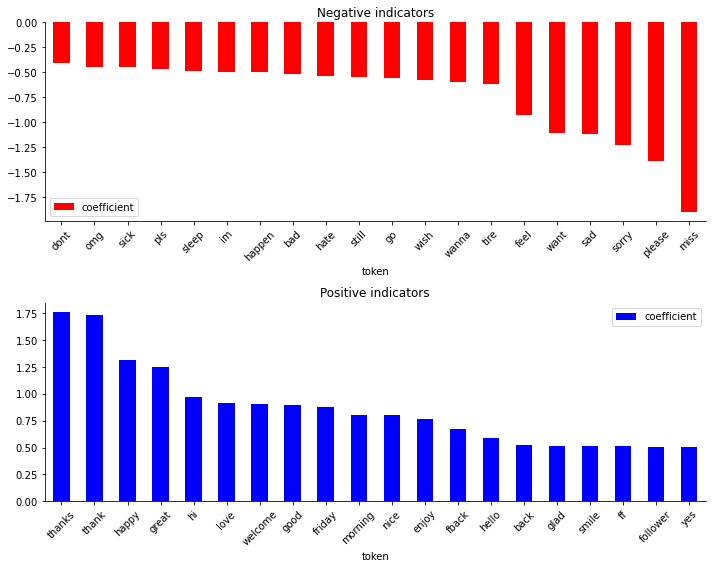

In [121]:
words = tfidf.get_feature_names()

def plot_coefs(logregTFIDF, words):
    coef_df = pd.DataFrame({"coefficient": logregTFIDF.coef_[0], "token": words})
    coef_df = coef_df.sort_values("coefficient", ascending=False)

    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # smallest coefficient -> tokens indicating negative sentiment 
    coef_df.tail(20).set_index("token").plot(kind="bar", rot=45, ax=axs[0], color="red")
    axs[0].set_title("Negative indicators")
 
    
    # largest coefficient -> tokens indicating positive sentiment 
    coef_df.head(20).set_index("token").plot(kind="bar", rot=45, ax=axs[1], color="blue")
    axs[1].set_title("Positive indicators")
    
    sns.despine()
    plt.tight_layout()
    plt.show()
    
plot_coefs(logregTFIDF, words)

### 1.4.B Finding the most optimal supervised learning model - Other supervised learning models

After the logistic regression, we are going to explore other supervised learning models. The models we are going to apply are: 

- K-Neighbors
- Decision Tree
- Support Vector Machine with three kernels: Radial Basis Function (RBF), polynomial and linear 
- Random Forest

In [122]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Instantiate models
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(max_depth=10)
svc = SVC(kernel='rbf') # Radial Basis Function (RBF) kernel
svc_poly = SVC(kernel='poly') # Polynomial kernel
linear_svc = LinearSVC() # Linear SVM
rf = RandomForestClassifier()
nn = MLPClassifier(hidden_layer_sizes=(10,10,10,10,10),solver='lbfgs')

# Fit models
knn.fit(X_train_TFIDF, y_train)
dt.fit(X_train_TFIDF, y_train)
svc.fit(X_train_TFIDF, y_train)
svc_poly.fit(X_train_TFIDF, y_train)
linear_svc.fit(X_train_TFIDF, y_train)
rf.fit(X_train_TFIDF, y_train)
nn.fit(X_train_TFIDF, y_train)

MLPClassifier(hidden_layer_sizes=(10, 10, 10, 10, 10), solver='lbfgs')

In [123]:
print(f'KNN train: {knn.score(X_train_TFIDF, y_train).round(3)} KNN test:{knn.score(X_test_TFIDF, y_test).round(3)}')
print(f'DT train: {dt.score(X_train_TFIDF, y_train).round(3)} DT test:{dt.score(X_test_TFIDF, y_test).round(3)}')
print(f'SVM RBF train: {svc.score(X_train_TFIDF, y_train).round(3)} SVM RBF Test:{svc.score(X_test_TFIDF, y_test).round(4)}')
print(f'SVM Polynomial train: {svc_poly.score(X_train_TFIDF, y_train).round(3)} Polynomial Test:{svc_poly.score(X_test_TFIDF, y_test).round(4)}')
print(f'SVM linear train: {linear_svc.score(X_train_TFIDF, y_train).round(3)} SVM linear test: {linear_svc.score(X_test_TFIDF, y_test).round(4)}')
print(f'Random Forest: {rf.score(X_train_TFIDF, y_train).round(3)} Random Forest: {rf.score(X_test_TFIDF, y_test).round(3)}')
print(f'Neural Network: {nn.score(X_train_TFIDF, y_train).round(3)} Neural Network: {nn.score(X_test_TFIDF, y_test).round(3)}')

KNN train: 0.752 KNN test:0.619
DT train: 0.621 DT test:0.59
SVM RBF train: 0.965 SVM RBF Test:0.7397
SVM Polynomial train: 0.984 Polynomial Test:0.718
SVM linear train: 0.941 SVM linear test: 0.7193
Random Forest: 0.987 Random Forest: 0.718
Neural Network: 0.837 Neural Network: 0.712



In our model, we don't have a class that we want to make an effort to predict better than the other. We want to predict all classes as well as possible. But it will be good to take a look on how the SVM model predicts both classes and if there is a class that is predicted better than the other.

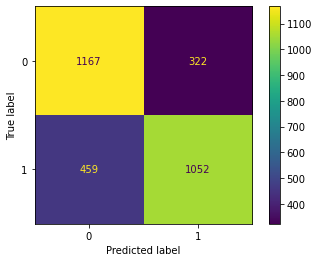

In [286]:
# Calculating confussion matrix for SVM-RBF model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_test_predict= svc.predict(X_test_TFIDF)
conf_matrix = confusion_matrix(y_test, y_test_predict)

ConfusionMatrixDisplay(conf_matrix).plot()

Conclusions:
- The Decision Tree is the model that gives the lowest accuracy.
- The KNN is the second last model in terms of accuracy on the test data set.
- Random forest looks very promising on the train data set but it is overfitting as it is not able to maintain the high accuracy score on the test data set.
- Neural Network does not overfit as much as the Random Forest but the SVM models give a best accuracy.
- **The Support Vector Machine model with a RBF kernel give us the best accuracy score** on the test data set. We will use this model

An advantage of the SVM models is that, unlike decision trees and KNN, SVM models are able to extrapolate to unseen values. This is an important consideration as we are building a model we will use to extrapolate to other data sets.

Looking at the confusion matrix we can see that both classes (0 - negative tweets and 1 - positive tweets) are predicted with similar accuracy.


### 1.5 Applying the model to the captured tweets


We have captured the tweets in another Jupyter notebook. We have done this to preserve the Twitter Developer API keys private.

We have exported the files and we will import them into this notebook.

Once the tweets are imported, we are going to:\
1 - check if there are any duplicated tweeets, and remove the duplicated tweets.\
2 - change the format of the columns: when we imported the tweets some of the data types where not imported correctly.\
3 - clean the tweets using the function that we have previously defined.\
4 - apply the TF-IDF vectorizer.\
5 - apply the SVM model that we have previously defied to the new tweets and assign the sentiment to each of the tweets

And here we finish the first part of the project. We have assigned a sentiment to each of the newly captured tweets.

In [270]:
tweets2 = pd.read_csv("data/tweets2.csv", dtype={'Text': str, 'Company': str} )
tweets3 = pd.read_csv("data/tweets3.csv", dtype={'Text': str, 'Company': str} )
tweets4 = pd.read_csv("data/tweets4.csv", dtype={'Text': str, 'Company': str} )
tweets5 = pd.read_csv("data/tweets5.csv", dtype={'Text': str, 'Company': str} )
tweets6 = pd.read_csv("data/tweets6.csv", dtype={'Text': str, 'Company': str} )
tweets7 = pd.read_csv("data/tweets7.csv", dtype={'Text': str, 'Company': str} )
tweets8 = pd.read_csv("data/tweets8.csv", dtype={'Text': str, 'Company': str} )
tweets9 = pd.read_csv("data/tweets9.csv", dtype={'Text': str, 'Company': str} )
tweets10 = pd.read_csv("data/tweets10.csv", dtype={'Text': str, 'Company': str} )
tweets11 = pd.read_csv("data/tweets11.csv", dtype={'Text': str, 'Company': str} )

In [271]:
# Putting all tweets together

all_tweets= pd.concat([tweets2, tweets3, tweets4, tweets5, tweets6, tweets7, tweets8, tweets9, tweets10, tweets11])

In [272]:
all_tweets.shape

(14635, 4)

In [273]:
# Checking if there are any duplicated tweets

len(all_tweets['Text'].unique())

6329

In [274]:
# Deleting all the duplicated tweets

all_tweets.drop_duplicates('Text', inplace=True)

In [275]:
all_tweets.shape

(6329, 4)

In [276]:
all_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6329 entries, 0 to 4204
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6329 non-null   object
 1   Date        6328 non-null   object
 2   Text        6328 non-null   object
 3   Company     6327 non-null   object
dtypes: object(4)
memory usage: 247.2+ KB


In [277]:
# Fixing the format of some of the columns from the "all_tweets" data base 

# When we imported the tweets it created an index column "Unnamed: 0", we don't need this column
all_tweets = all_tweets.drop(['Unnamed: 0'], axis=1)

# When we imported the tweets the "Date" column was not imported with the proper format
all_tweets['Date'] = pd.to_datetime(all_tweets['Date'])

# When we imported the tweets the "Text" column was not imported with the proper format
all_tweets['Text'] = all_tweets['Text'].astype(str)

In [278]:
# Cleaning the tweets

all_tweets["Text"] = all_tweets["Text"].apply(lambda x: clean_tweet(x))

In [280]:
all_tweets.head(-10)

,Date,Text,Company
0,2020-12-14 02:10:46,friday top flow consumer discretionary sector ...,NKE
1,2020-12-14 02:09:11,nke check chart make,NKE
2,2020-12-14 02:08:33,big consumer trend look stock wmt tgt cost amz...,NKE
3,2020-12-14 02:06:41,rt uneventful earnings week upcoming:\n\nhere ...,NKE
4,2020-12-14 02:05:44,rt earnings week \n\n \n\n$fdx hexo rad nke cl...,NKE
...,...,...,...
3502,2020-12-19 20:26:32,someone explain tsla call others around way high,TSLA
3504,2020-12-19 20:25:54,rt another ath tsla another ath 🥂🙌🏻🚀\n\ncongra...,TSLA
4175,2020-12-19 09:41:34,smartoptions® unusual activity alert\n(delayed...,AAPL
4176,2020-12-19 09:38:52,rt aapl generate fcf public company india coll...,AAPL


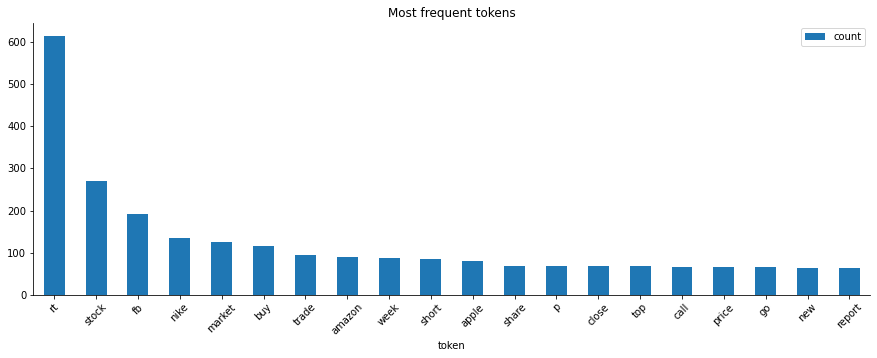

In [281]:
# Vectorizing using TF-IDF 

Tweets_trans = tfidf.transform(all_tweets['Text'])

words = tfidf.get_feature_names()
word_weights = Tweets_trans.toarray().sum(axis=0)

plot_most_frequent(words, word_weights)

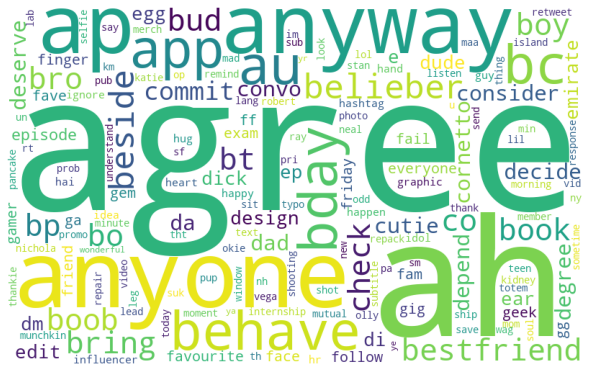

In [282]:
from PIL import Image
from os import path
from wordcloud import WordCloud, STOPWORDS
from IPython.display import Image as im


temp=' '.join(words_tfidf)
wordcloud = WordCloud(width = 800, height = 500, 
                background_color ='white', 
                min_font_size = 10).generate(temp)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()

In [283]:
# Applyng the SVM model to the tweets to assign sentiment to each of the tweets

all_tweets['Sentiment'] = svc.predict(Tweets_trans)

In [284]:
all_tweets.head(-10)

,Date,Text,Company,Sentiment
0,2020-12-14 02:10:46,friday top flow consumer discretionary sector ...,NKE,1
1,2020-12-14 02:09:11,nke check chart make,NKE,1
2,2020-12-14 02:08:33,big consumer trend look stock wmt tgt cost amz...,NKE,1
3,2020-12-14 02:06:41,rt uneventful earnings week upcoming:\n\nhere ...,NKE,1
4,2020-12-14 02:05:44,rt earnings week \n\n \n\n$fdx hexo rad nke cl...,NKE,0
...,...,...,...,...
3502,2020-12-19 20:26:32,someone explain tsla call others around way high,TSLA,0
3504,2020-12-19 20:25:54,rt another ath tsla another ath 🥂🙌🏻🚀\n\ncongra...,TSLA,0
4175,2020-12-19 09:41:34,smartoptions® unusual activity alert\n(delayed...,AAPL,0
4176,2020-12-19 09:38:52,rt aapl generate fcf public company india coll...,AAPL,1




## 2. Predicting Stock Movement


We have assigned the sentiments for the tweets, now it's the moment of truth. See if the sentiment can predict the stock value movement.

For check if sentiment is a good predictor, first we will need to capture the data from the stock market. 

Once the data is captured we will create a new variable `Movement` which will take the following values:
- **1** if the stock value movement for a particular company for that day goes **up**
- **0** if the stock value movement for a particular company for that day goes **down**

### 2.1. Capturing stock market data

In [368]:
# Yahoo finance needs to be installed through the terminal ->$ pip install yfinance --upgrade --no-cache-dir

import yfinance as yf

stocks = yf.download("AMZN AAPL MRK NKE TSLA", start="2020-12-10", end="2020-12-20")
stocks

[*********************100%***********************]  5 of 5 completed


Adj Close                                                  \
                  AAPL         AMZN        MRK         NKE        TSLA   
Date                                                                     
2020-12-10  123.239998  3101.489990  82.339767  137.580002  627.070007   
2020-12-11  122.410004  3116.419922  82.309998  137.410004  609.989990   
2020-12-14  121.779999  3156.969971  80.320000  136.279999  639.830017   
2020-12-15  127.879997  3165.120117  80.480003  139.389999  633.250000   
2020-12-16  127.809998  3240.959961  79.830002  138.339996  622.770020   
2020-12-17  128.699997  3236.080078  79.820000  140.500000  655.900024   
2020-12-18  126.660004  3201.649902  79.529999  137.279999  695.000000   

                 Close                                                  ...  \
                  AAPL         AMZN        MRK         NKE        TSLA  ...   
Date                                                                    ...   
2020-12-10  123.239998  3101.489990  82.989998  137.580002  627.070007  ...   
2020-12-11  122.410004  3116.419922  82.959999  137.410004  609.989990  ...   
2020-12-14  121.779999  3156.969971  80.320000  136.279999  639.830017  ...   
2020-12-15  127.879997  3165.120117  80.480003  139.389999  633.250000  ...   
2020-12-16  127.809998  3240.959961  79.830002  138.339996  622.770020  ...   
2020-12-17  128.699997  3236.080078  79.820000  140.500000  655.900024  ...   
2020-12-18  126.660004  3201.649902  79.529999  137.279999  695.000000  ...   

                  Open                                                  \
                  AAPL         AMZN        MRK         NKE        TSLA   
Date                                                                     
2020-12-10  120.500000  3088.989990  83.660004  138.279999  574.369995   
2020-12-11  122.430000  3096.659912  82.849998  137.389999  615.010010   
2020-12-14  122.599998  3143.000000  82.629997  138.919998  619.000000   
2020-12-15  124.339996  3181.010010  80.500000  137.429993  643.280029   
2020-12-16  127.410004  3176.010010  80.279999  139.070007  628.229980   
2020-12-17  128.899994  3250.000000  80.389999  139.919998  628.190002   
2020-12-18  128.960007  3243.989990  79.709999  141.089996  668.900024   

               Volume                                          
                 AAPL     AMZN       MRK       NKE       TSLA  
Date                                                           
2020-12-10   81312200  3030200   7012600   4511000   67083200  
2020-12-11   86939800  3064700   7613700   4172400   46475000  
2020-12-14   79184500  4155800  12537500   7599000   52040600  
2020-12-15  157572300  3323700   9626700   7642600   45223600  
2020-12-16   98208600  4427600   9053100   6573400   42095800  
2020-12-17   94359800  3474300  11173700   8727000   56270100  
2020-12-18  192354800  5971700  31641100  17898600  218741900  

[7 rows x 30 columns]

In [369]:
# Dropping the columns we don't need

stocks = stocks.drop(['High', 'Close' , 'Low', 'Volume'], axis=1)

In [370]:
# Checking we have the correct columns

stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7 entries, 2020-12-10 to 2020-12-18
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, AAPL)  7 non-null      float64
 1   (Adj Close, AMZN)  7 non-null      float64
 2   (Adj Close, MRK)   7 non-null      float64
 3   (Adj Close, NKE)   7 non-null      float64
 4   (Adj Close, TSLA)  7 non-null      float64
 5   (Open, AAPL)       7 non-null      float64
 6   (Open, AMZN)       7 non-null      float64
 7   (Open, MRK)        7 non-null      float64
 8   (Open, NKE)        7 non-null      float64
 9   (Open, TSLA)       7 non-null      float64
dtypes: float64(10)
memory usage: 616.0 bytes


In [371]:
# Taking out the multiple indeces and semi transposing the date and the ticker as a value

stocks = stocks.stack(1).rename_axis(('Date','Ticker')).reset_index(level=1)
stocks.head(10)

,Ticker,Adj Close,Open
Date,,,
2020-12-10,AAPL,123.239998,120.500000
2020-12-10,AMZN,3101.489990,3088.989990
2020-12-10,MRK,82.339767,83.660004
2020-12-10,NKE,137.580002,138.279999
2020-12-10,TSLA,627.070007,574.369995
2020-12-11,AAPL,122.410004,122.430000
2020-12-11,AMZN,3116.419922,3096.659912
2020-12-11,MRK,82.309998,82.849998
2020-12-11,NKE,137.410004,137.389999


In [372]:
# Calculating if the stock goes up or down

stocks['Movement']= np.where( stocks['Adj Close'] / stocks['Open'] < 1 , 0 , 1)
stocks.reset_index(inplace=True)
stocks.head(10)

,Date,Ticker,Adj Close,Open,Movement
0,2020-12-10,AAPL,123.239998,120.500000,1
1,2020-12-10,AMZN,3101.489990,3088.989990,1
2,2020-12-10,MRK,82.339767,83.660004,0
3,2020-12-10,NKE,137.580002,138.279999,0
4,2020-12-10,TSLA,627.070007,574.369995,1
5,2020-12-11,AAPL,122.410004,122.430000,0
6,2020-12-11,AMZN,3116.419922,3096.659912,1
7,2020-12-11,MRK,82.309998,82.849998,0
8,2020-12-11,NKE,137.410004,137.389999,1
9,2020-12-11,TSLA,609.989990,615.010010,0


### 2.2. Average sentiment vs Stock value daily movement

With the stock value data we can now explore if there is any relationship between sentiment and stock value movement. To see if there is any relationship we are try two methods:

1 - Average guesses\
2 - Other methods: correlation and chi-squared



#### 2.2.A. Average guesses

In this method we are going to explore the percentage of times the sentiment has correctly predicted the stock value movement.

1 - We will add one more day to the sentiment, for example: if we have calculated the average sentiment for December 10th, we will add one more day so it will be the average sentiment for December 11th. We are doing this because we want to see if the sentiment can predict the stock value for the following day.

2 - We will calculate the average sentiment for a particular stock and a particular day, and we will create a binary variable where:
    - If average sentiment is < 0.5 => sentiment will be negative, that is 0
    - If average sentiment is >= 0.5 => sentiment will be positive, that is 1

    
3 - We will merge both the financial data set with the average sentiment data set.


4 - We will compare if both stock value movement and average sentiment have any correlation, in particular we are going create a new variable that will calculate the accuracy of the prediction. The values of the new variable `accuracy` variable will be :
    - If sentiment is positive and the stock movement is up, it's a correct guess => accuracy = 1
    - If sentiment is negative and the stock movement is down, it's a correct guess => accuracy = 1
    - All the other cases the prediction is not correct therefore => accuracy = 0   

5 - We will calculate the percentage of accurate predictions.




In [374]:
# ADDING ONE MORE DAY TO THE DATE

# Only take into account the day and disregard the time we have in the timestamp
import datetime as dt
all_tweets['Cal_date'] = all_tweets['Date'].dt.date

# Transforming the variable date from an object to a date type variable
all_tweets['Cal_date']= pd.to_datetime(all_tweets['Cal_date'])

# Adding one more day to the day of the Average Sentiment.
# We are going to compare this day+1 with the day from the stock market data
from datetime import datetime
from datetime import timedelta

all_tweets['Date_plus1'] = (all_tweets['Cal_date'] + timedelta(days=1))

all_tweets.head(10)

,Date,Text,Company,Sentiment,Cal_date,Date_plus1
0,2020-12-14 02:10:46,friday top flow consumer discretionary sector ...,NKE,1,2020-12-14,2020-12-15
1,2020-12-14 02:09:11,nke check chart make,NKE,1,2020-12-14,2020-12-15
2,2020-12-14 02:08:33,big consumer trend look stock wmt tgt cost amz...,NKE,1,2020-12-14,2020-12-15
3,2020-12-14 02:06:41,rt uneventful earnings week upcoming:\n\nhere ...,NKE,1,2020-12-14,2020-12-15
4,2020-12-14 02:05:44,rt earnings week \n\n \n\n$fdx hexo rad nke cl...,NKE,0,2020-12-14,2020-12-15
5,2020-12-14 02:04:54,rt top stock pick week:\n$acn top watchlist we...,NKE,1,2020-12-14,2020-12-15
8,2020-12-14 01:52:45,nke check chart make \n\nwell work,NKE,1,2020-12-14,2020-12-15
9,2020-12-14 01:29:29,need know option week\n$tsla spy nke bb fdx\n\n,NKE,0,2020-12-14,2020-12-15
12,2020-12-14 01:24:19,free trial available,NKE,1,2020-12-14,2020-12-15
13,2020-12-14 01:21:11,interest company week giant nike fedex accentu...,NKE,0,2020-12-14,2020-12-15


In [375]:
# CALCULATING THE AVERAGE SENTIMENT FOR A DAY AND COMPANY

Average_sentiment = pd.DataFrame(all_tweets.groupby(['Company','Date_plus1'])['Sentiment'].mean())
Average_sentiment.reset_index(level=0, inplace=True)

Average_sentiment.head(10)

,Company,Sentiment
Date_plus1,,
2020-12-14,AAPL,0.388889
2020-12-15,AAPL,0.411215
2020-12-16,AAPL,0.482143
2020-12-19,AAPL,0.442308
2020-12-20,AAPL,0.419291
2020-12-21,AAPL,0.356061
2020-12-15,AMZN,0.472826
2020-12-16,AMZN,0.419872
2020-12-19,AMZN,0.486188


In [376]:
# TURNING THE AVERAGE SENTIMENT TO A BINARY VARIABLE

Average_sentiment['Daily_sent']= np.where( Average_sentiment['Sentiment'] < 0.5 , 0 , 1)
Average_sentiment.reset_index(inplace=True)
Average_sentiment.head(10)

,Date_plus1,Company,Sentiment,Daily_sent
0,2020-12-14,AAPL,0.388889,0
1,2020-12-15,AAPL,0.411215,0
2,2020-12-16,AAPL,0.482143,0
3,2020-12-19,AAPL,0.442308,0
4,2020-12-20,AAPL,0.419291,0
5,2020-12-21,AAPL,0.356061,0
6,2020-12-15,AMZN,0.472826,0
7,2020-12-16,AMZN,0.419872,0
8,2020-12-19,AMZN,0.486188,0
9,2020-12-20,AMZN,0.410839,0


In [377]:
# MERGING BOTH THE TWEETS SENTIMENT AND THE FINANCIAL DATA SETS

# The data frames are merged by:
#    -  the date+1 from sentiment and the day
#    -  the company ticker

all = Average_sentiment.merge(stocks, left_on=['Date_plus1','Company'], right_on = ['Date','Ticker'], how='inner')
all.head(10)

,Date_plus1,Company,Sentiment,Daily_sent,Date,Ticker,Adj Close,Open,Movement
0,2020-12-14,AAPL,0.388889,0,2020-12-14,AAPL,121.779999,122.599998,0
1,2020-12-15,AAPL,0.411215,0,2020-12-15,AAPL,127.879997,124.339996,1
2,2020-12-16,AAPL,0.482143,0,2020-12-16,AAPL,127.809998,127.410004,1
3,2020-12-15,AMZN,0.472826,0,2020-12-15,AMZN,3165.120117,3181.010010,0
4,2020-12-16,AMZN,0.419872,0,2020-12-16,AMZN,3240.959961,3176.010010,1
5,2020-12-14,MRK,0.370130,0,2020-12-14,MRK,80.320000,82.629997,0
6,2020-12-15,MRK,0.366492,0,2020-12-15,MRK,80.480003,80.500000,0
7,2020-12-16,MRK,0.299435,0,2020-12-16,MRK,79.830002,80.279999,0
8,2020-12-17,MRK,0.367647,0,2020-12-17,MRK,79.820000,80.389999,0
9,2020-12-18,MRK,0.363636,0,2020-12-18,MRK,79.529999,79.709999,0


In [378]:
# Calculating the accuracy of the prediction. 
# If the sentiment + = the movement  up -> correct guess => accuracy 1
# If the sentiment - = the movement down -> correct guess => accuracy 1
# In all the other cases the prediction is not a correct prediction  => accuracy 0

all['Accuracy'] = np.where(all['Daily_sent'] == all['Movement'] , 1, 0)
all

,Date_plus1,Company,Sentiment,Daily_sent,Date,Ticker,Adj Close,Open,Movement,Accuracy
0,2020-12-14,AAPL,0.388889,0,2020-12-14,AAPL,121.779999,122.599998,0,1
1,2020-12-15,AAPL,0.411215,0,2020-12-15,AAPL,127.879997,124.339996,1,0
2,2020-12-16,AAPL,0.482143,0,2020-12-16,AAPL,127.809998,127.410004,1,0
3,2020-12-15,AMZN,0.472826,0,2020-12-15,AMZN,3165.120117,3181.010010,0,1
4,2020-12-16,AMZN,0.419872,0,2020-12-16,AMZN,3240.959961,3176.010010,1,0
5,2020-12-14,MRK,0.370130,0,2020-12-14,MRK,80.320000,82.629997,0,1
6,2020-12-15,MRK,0.366492,0,2020-12-15,MRK,80.480003,80.500000,0,1
7,2020-12-16,MRK,0.299435,0,2020-12-16,MRK,79.830002,80.279999,0,1
8,2020-12-17,MRK,0.367647,0,2020-12-17,MRK,79.820000,80.389999,0,1
9,2020-12-18,MRK,0.363636,0,2020-12-18,MRK,79.529999,79.709999,0,1


In [389]:
print(f'The prediction is accurate in {all["Accuracy"].mean()*100} % of the cases')

The prediction is accurate in 70.58823529411765 % of the cases


#### 2.2.B. Exploring other methods 

I would like to explore other methods to determine if the sentiment and stock market movement are correlated.

Because we don't have a training set, we  cannot use supervised learning methods like logistic regression.

But there are other methods that we can use:

1 - Calculate correlation between the `Daily_sent` (daily sentiment) and `Movement` variables\
2 - Use the Chi-squared test for independence

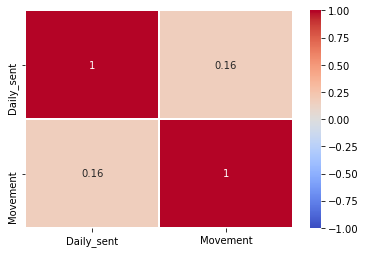

In [383]:
# Calculating the correlation between the sentiment and market movement variables

X = all[['Daily_sent', 'Movement']]
plt.figure()
sns.heatmap(X.corr(), cmap='coolwarm', vmin=-1, vmax=1, annot=True, lw=1)
plt.show()

With a 0.16, we can see the correlation between the daily sentiment and the stock market movement is very low.

We cannot conclude that the daily sentiment is correlated with the stock market movement.

#### 2.2.B. Chi squared test for independence

The Chi-squared test is to determine if there is any relationship between 2 categorical variables.

Our null hypothesis is:\
$H_0:$Sentiment and Stock movement are independent, they are not related to each other.\
$H_1:$Sentiment and Stock movement are dependent, they are somewhat related to each other.

In [394]:
# Calculating the data for the data frame 

Chi_squared = pd.DataFrame(all.groupby(['Daily_sent','Movement'])['Movement'].count())
Chi_squared

Movement
Daily_sent Movement          
0          0               11
           1                4
1          0                1
           1                1

In [400]:
# Creating the data frame

Chi_squared2 = {'Down_movement': [11,1], 'Up_movement':[4,1]}
Chi_squared2 = pd.DataFrame(Chi_squared2, index=['Neg_Sent', 'Pos_Sent'])
display(Chi_squared2)

,Down_movement,Up_movement
Neg_Sent,11,4
Pos_Sent,1,1


In [404]:
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import norm
import math

stats.chi2_contingency(Chi_squared2)

(0.021249999999999977,
 0.8840999615800735,
 1,
 array([[10.58823529,  4.41176471],
        [ 1.41176471,  0.58823529]]))

The p is 0.88, much more than 0.05 threshold that will allows to reject the null hypothesis. With a p over 0.05 we cannot reject the Ho hypothesis. We cannot reject that both variables are independent, so both variables are not dependent on each other, the stock market movement is not dependent on the captured sentiment with tweets. 

This test is coherent with the result we got for the correlation matrix.

Therefore, even if we have a high percentage of guesses right, we can conclude that this is result of luck and that the sentiment captured from tweets cannot predict the movement of the stock market.



## Conclusion

We can conclude that the **sentiment captured with tweets is not a good predictor of the stock market movement.** 

This model could be improved by:
- Refining the techniques used to clean the tweets: if we had better data, the model could yield better results.
- Assigning sentiment with an unsupervised learning method like polarization: we are using a model trained on general tweets, if we could add more specificity to how we label the sentiment, we should be able to assess the sentiment better, and we might have more accurate results.
